In [4]:
import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# download and load the training data
trainset = datasets.FashionMNIST('~/datasets/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# download and load the test data
testset = datasets.FashionMNIST('~/datasets/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

print("done")

done


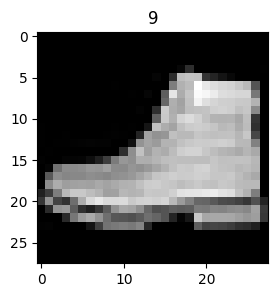

In [6]:
# visualize the data - one image
image, label = next(iter(trainloader))
image = image[0].numpy().squeeze()
label = label[0].numpy()

fig = plt.figure(figsize=(3, 3))
plt.imshow(image, cmap='gray')
plt.title(label)
plt.show()


In [9]:
# image is 28 x 28 pixels, so 784 pixels in total
# input layer has 784 units
# output layer has 10 units, one for each class

# define the network architecture

class Network(torch.nn.Module):

    def __init__(self):
        super().__init__()

        # define the layers
        self.fc1 = torch.nn.Linear(784, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 64)
        self.fc4 = torch.nn.Linear(64, 10)

        # define the activation functions
        self.relu = torch.nn.ReLU()
        self.logsoftmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):

        # flatten
        x = x.view(x.shape[0], -1)

        # pass through the layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.logsoftmax(x)

        return x
    

In [10]:
model = Network()

# define the loss function
criterion = torch.nn.NLLLoss()

# define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [12]:
# train the network

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# model
model = model.to(device)

# loss function
criterion = criterion.to(device)

# train the network
epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        # Move the data to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {e+1}/{epochs}, Training loss: {running_loss/len(trainloader)}")
    
print("done")

Using device: cuda
Epoch 1/10, Training loss: 0.4362266127393444
Epoch 2/10, Training loss: 0.4167011547158522
Epoch 3/10, Training loss: 0.4001632405560154
Epoch 4/10, Training loss: 0.38691892463769484
Epoch 5/10, Training loss: 0.37235836430526237
Epoch 6/10, Training loss: 0.3613976474160325
Epoch 7/10, Training loss: 0.35259818971188844
Epoch 8/10, Training loss: 0.3429624182678489
Epoch 9/10, Training loss: 0.3346085437357044
Epoch 10/10, Training loss: 0.3262652020051535
done


In [19]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''

    ps = ps.cpu()
    img = img.cpu()

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

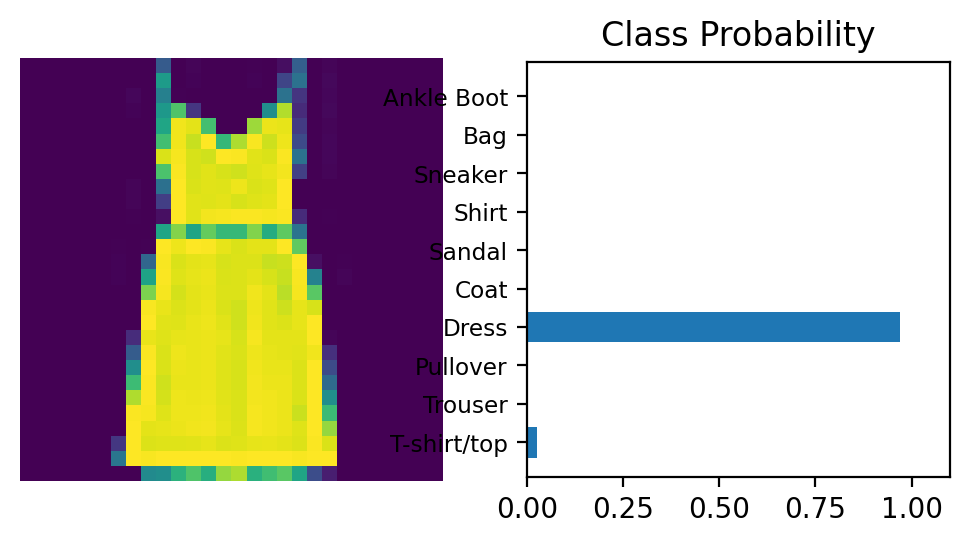

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Test out the network

dataiter = iter(testloader)
images, labels = next(dataiter)

# Get the class probabilities
img = images[0]
img = img.to(device)
img = img.view(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)

# Plot the image and probabilities
view_classify(img.view(1, 28, 28), ps, version='Fashion')
